In [1]:
from ch_est_net.preloading import *
from ch_est_net.utils import *

%load_ext autoreload
%autoreload 2

In [5]:
cfg, dataL, dataS, device, deviceType, dtype, file, ml_default, onePilotFolder, path ,preload, print_function, scen0, Scenario = crazy_preloader()

Using CPU

Preload data: OK


*Functions for the Beam-transformation and Beam-approximation*

In [3]:
from scipy import linalg as LA 
import math

def transform_to_beams(H, all_beams, axis = 0):
    '''
    Transforms channel into beam the domain,
    by matrix multiplication to DFT matrix.
    -------------------------------------------------------------
    |           DFT                  H               Res        |
    | [all_beams ; antennas] @ [antennas ; X] = [all_beams ; X] |
    |                                                           |
    | where: X - subc or time domain  ;  all_beams > antennas   | 
    -------------------------------------------------------------
    
    params:
    H - COMPLEX valued chanel coeffs (usually:[64,48])
    all_beams - number of beams to which channel will be projected
    axis - which axis multiply to DFT. Here should be antenna axis.

    returns:
    H - COMPLEX channel coeff in the beam domain (usually:[beams, subc])
    ''' 

    DFT = LA.dft(all_beams)/math.sqrt(all_beams)                        # generate DFT NORMALIZED matrix
    IDFT = DFT.conj()                                                   # generate IDFT NORMALIZED also

    DFT = torch.tensor(DFT, dtype= torch.cfloat)                        # Transform to Torch tensor
    IDFT = torch.tensor(IDFT, dtype= torch.cfloat)

    if axis == 1:                                                       # If second dim is antenna space
        H = H.T                                                         # Transpose to have antenna space on the 1nd dim
        axis = 0

    if axis == 0:                                                       # If first dim is anntena space
        cols = H.shape[0]                                               # How many antennas we have
        H = DFT[:,:cols] @ H                                            # Slice DFT and multiply

    return H
    

def beam_approximate(H, all_beams, clear_beams, axis = 0):
    '''
    Applies beam-approximation. Transforms channel into the beam domain
    with @all_beams number of beams, calculate power for each beam, 
    select @clear_beams most powerfull ones, and makes other beams - zero,
    transforms approximated channel to antenna space back. 
    
    args:
    H - COMPLEX valued chanel coeffs (usually:[64,48])
    all_beams - number of beams to which channel will be projected
    clear_beams - number of beam that only will be used for approximation.
    axis - which axis multiply to DFT. Here should be antenna axis.
    
    returns:
    Aproximated COMPLEX-valued channel in the initial form
    '''
    DFT = LA.dft(all_beams)/math.sqrt(all_beams)                        # generate DFT NORMALIZED matrix
    IDFT = DFT.conj()                                                   # IDFT NORMALIZED matrix

    DFT = torch.tensor(DFT, dtype= torch.cfloat)                        # Transform to Torch tensor
    IDFT = torch.tensor(IDFT, dtype= torch.cfloat)  
    cols = 0 

    if axis == 1:                                                       # If second dim is antenna space
        H = H.T                                                         # Transpose to have antenna space on the 1nd dim
        axis = 0

    if axis == 0:                                                       # If first dim is anntena space
        cols = H.shape[0]                                               # Number of antennas
        H = DFT[:,:cols] @ H                                            # Slice DFT and multiply

    Power = torch.sum(abs(H)**2, dim = 1)                               # Calculate power over 1-dim
    idxs = torch.argsort(Power, descending= True)[clear_beams:]         # Sort and select beams that will be deleted
    
    H[idxs,:] = 0                                                       # delete beams

    H = IDFT[:cols,:] @ H                                               # Transform back to antenna domain

    return H


def beam_denoise(H, all_beams, clear_beams, axis = 0):
    '''
    Applies beam approximation for real values channel 
    (where real and imag parts has different dims),
    returns aproximated channel in initial form.

    args:
    H - COMPLEX valued chanel coeffs (usually:[64,48])
    all_beams - number of beams to which channel will be projected
    clear_beams - number of beam that only will be used for approximation.
    axis - which axis multiply to DFT. Here should be antenna axis.
    
    returns:
    Aproximated Real-valued channel in the initial form
    '''

    ans = torch.empty_like(H)
    
    H =  H[:,:,0] +1j*H[:,:,1]
    H = beam_approximate(H, all_beams, clear_beams,axis)
    
    ans[:,:,0] = H.real
    ans[:,:,1] = H.imag
    
    return ans

**Loading train file and plotting it**

**Creating neural net **

In [12]:

'''Функция предсказания. Прогоняет данные для всех указанных SNR и файлов'''
def beam_preds(  all_beams, clear_beams, dtype, onePilotFolder,dataL, ml = ml_default, 
            lossVersion='detector', # 'detector' or 'relError'
            inds=range(1,141), 
            SNR_L=range(-10,-1), 
            seed=4, 
            max_iter=3, 
            ml_version=12, 
            SNRscaleFactor=1.,
            scen=scen0, scale=True):
    assert lossVersion in ['detector', 'relError']
    N_used = scen.RB_num*scen.RB_size
    loss = []
    comb = scen.comb

    z = torch.zeros(64, 512, 2, requires_grad = False)
    h_hat = torch.zeros(64, 512, 2, requires_grad = False) 

    losses = []

    if lossVersion == 'detector':
        N_pilot_sym = scen.N_pilot*scen.N_TTI
        N_data_sym = (14-N_pilot_sym)*scen.N_TTI;
        for SNR in SNR_L:
            loss_current = 0
            for ind in inds:
                h_pilot, h_data = data_load(scen, dtype = dtype, onePilotFolder = onePilotFolder,dataL = dataL, ind = ind+1 ,use_preloaded = False)
                h_pilot_noisy, _ = add_noise(h_pilot, SNR, scen=scen0, dtype=dtype, seed=seed)
                h_data_noisy, data_noise_power = add_noise_data(h_data, SNR,dtype= dtype, seed=seed) 

                u = h_pilot_noisy.mean(dim=2)

                # CHANNEL ESTIMATION # оценка канала 
                #preds = NET.forward(u = u)
                h_pilot_rec = beam_denoise(H = u, all_beams=all_beams, clear_beams=clear_beams)
                
                # Show time domain recovered and initial signals
                if ind % 70==-1:
                    h_pilot_rec_numpy = upsampling(scen, h_pilot_rec, inverse=False).detach().numpy()
                    plt.plot(h_pilot_rec_numpy[0,:,0]**2+h_pilot_rec_numpy[0,:,1]**2)
                    h_f = h_pilot
                    if len(h_f.shape) == 4:
                        h_f = h_f.mean(dim=2)
                    h_f = upsampling(scen, h_f, inverse=False).detach().numpy()
                    plt.plot(h_f[0,:,0]**2+h_f[0,:,1]**2)
                    plt.show()            
                assert h_pilot_rec.shape[1] == N_used
                H_re = h_pilot_rec[:, :, 0]
                H_im = -h_pilot_rec[:, :, 1]
                
                # Detector error calculation
                err_data = 0
                for k in range (N_data_sym):    
                    det_data = torch.zeros((N_used, 2))   
                    assert h_data_noisy.shape[1] == N_used 
                    Y = h_data_noisy[:, :, k, :]                    
                    det_data[:,0] = (torch.sum(Y[:,:,0]*H_re-Y[:,:,1]*H_im, dim=0)/
                                    (data_noise_power+torch.sum(H_re**2+H_im**2, dim=0)))
                    det_data[:,1] = (torch.sum(Y[:,:,1]*H_re+Y[:,:,0]*H_im, dim=0)/
                                    (data_noise_power+torch.sum(H_re**2+H_im**2, dim=0)))
                      
                    err = det_data - torch.Tensor([1.,0.])  
                    err_data = err_data+torch.sum(err**2)
    
                loss_current += err_data/(N_data_sym*N_used)

                cur = {'loss': err_data.detach().numpy() ,'SNR': SNR, 'file': ind}
                losses.append(cur)

            loss.append(loss_current)        
            
    return loss, losses

In [13]:
# Вызов функции
SNR_range = range(-12,1,3)
scenario_range = range(1, 140, 2)

detector_error_beam_net_1, losses = beam_preds(all_beams = 64, clear_beams = 16, 
            dtype = dtype, onePilotFolder=onePilotFolder,dataL=dataL,
            inds=scenario_range,
            scen = scen0,
            SNR_L=SNR_range)

detector_error_beam_net_2, losses = beam_preds(all_beams = 64, clear_beams = 10,
            dtype = dtype, onePilotFolder=onePilotFolder,dataL=dataL,
            inds=scenario_range,
            scen = scen0,
            SNR_L=SNR_range)

detector_error_beam_net_3, losses = beam_preds(all_beams = 64, clear_beams = 5, 
            dtype = dtype, onePilotFolder=onePilotFolder,dataL=dataL,
            inds=scenario_range,
            scen = scen0,
            SNR_L=SNR_range)

detector_error_beam_net_4, losses = beam_preds(all_beams = 64, clear_beams = 3,
            dtype = dtype, onePilotFolder=onePilotFolder,dataL=dataL,
            inds=scenario_range,
            scen = scen0,
            SNR_L=SNR_range)

In [17]:

detector_error_beam_net_11, losses = beam_preds(all_beams= 512, clear_beams = 70, 
            dtype = dtype, onePilotFolder=onePilotFolder,dataL=dataL,
            inds=scenario_range,
            scen = scen0,
            SNR_L=SNR_range)

detector_error_beam_net_12, losses = beam_preds(all_beams= 512, clear_beams = 60,
            dtype = dtype, onePilotFolder=onePilotFolder,dataL=dataL,
            inds=scenario_range,
            scen = scen0,
            SNR_L=SNR_range)

detector_error_beam_net_13, losses = beam_preds(all_beams = 512, clear_beams=50, 
            dtype = dtype, onePilotFolder=onePilotFolder,dataL=dataL,
            inds=scenario_range,
            scen = scen0,
            SNR_L=SNR_range)

detector_error_beam_net_14, losses = beam_preds(all_beams= 512, clear_beams=40,
            dtype = dtype, onePilotFolder=onePilotFolder,dataL=dataL,
            inds=scenario_range,
            scen = scen0,
            SNR_L=SNR_range)

In [33]:
reference = [20.1498, 11.0312,6.0139, 3.6551, 3.4109 ]
noise = [57.8161, 47.5496, 34.0860, 20.339, 9.9376]

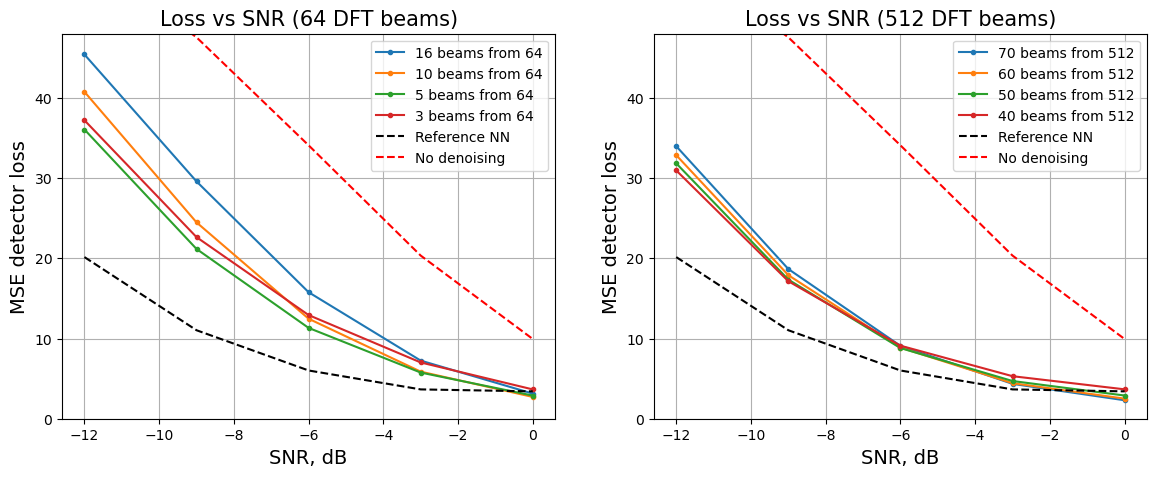

In [36]:
import matplotlib.pyplot as plt
plt.style.use("default")

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(SNR_range,detector_error_beam_net_1,'.-' ,label = '16 beams from 64')
plt.plot(SNR_range,detector_error_beam_net_2,'.-' ,label = '10 beams from 64' )
plt.plot(SNR_range,detector_error_beam_net_3,'.-' ,label = '5 beams from 64' )
plt.plot(SNR_range,detector_error_beam_net_4,'.-',label = '3 beams from 64' )
plt.plot(SNR_range,reference,'--k',label = 'Reference NN' )
plt.plot(SNR_range,noise,'--r',label = 'No denoising' )

plt.legend()
plt.title("Loss vs SNR (64 DFT beams)", fontsize = 15)
plt.xlabel("SNR, dB" , fontsize = 14)
plt.ylabel("MSE detector loss", fontsize = 14);
plt.ylim([0 , 48])
plt.grid()

plt.subplot(1,2,2)
plt.plot(SNR_range,detector_error_beam_net_11,'.-' ,label = '70 beams from 512')
plt.plot(SNR_range,detector_error_beam_net_12,'.-' ,label = '60 beams from 512' )
plt.plot(SNR_range,detector_error_beam_net_13,'.-' ,label = '50 beams from 512' )
plt.plot(SNR_range,detector_error_beam_net_14,'.-',label = '40 beams from 512' )
plt.plot(SNR_range,reference,'--k',label = 'Reference NN' )
plt.plot(SNR_range,noise,'--r',label = 'No denoising' )
plt.legend()
plt.title("Loss vs SNR (512 DFT beams)", fontsize = 15)
plt.xlabel("SNR, dB" , fontsize = 14)
plt.ylabel("MSE detector loss", fontsize = 14);
plt.ylim([0 , 48])
plt.grid()


plt.show()

**Plots for beam domain**

In [64]:
n_subc = 48
N_t = 64
ind = 85
SNR = -0
seed = 5

h_pilot, h_data = data_load(scen = scen0,dtype = dtype, onePilotFolder= onePilotFolder, dataL=dataL, ind=ind) # комплексные частотные характеристики для пилотных и информационных символов
h_pilot_noisy, _ = add_noise(h_pilot, SNR = SNR, scen= scen0, dtype = dtype, seed=seed) # получаем зашумленный пилот
h_data_noisy, data_noise_power = add_noise_data(h_data, SNR = SNR, dtype = dtype, seed = seed)

h_ideal = h_pilot.mean(dim = 2)
u = h_pilot_noisy.mean(dim = 2)

H_ant = h_ideal[:,:,0] + 1j*h_ideal[:,:,1] 
U_ant = u[:,:,0] + 1j*u[:,:,1] 

print(U_ant.shape)

torch.Size([64, 48])


In [65]:
BEAMS = 64
CLEAR_BEAMS = 10

DFT = LA.dft(BEAMS)/math.sqrt(BEAMS)
IDFT = DFT.conj()

DFT = torch.tensor(DFT, dtype= torch.cfloat)
IDFT = torch.tensor(IDFT, dtype= torch.cfloat)  

cols = U_ant.shape[0]
H_beam = DFT[:,:cols] @ H_ant 
U_beam = DFT[:,:cols] @ U_ant 

H_Power = torch.sum(abs(H_beam)**2, dim = 1)
U_Power = torch.sum(abs(U_beam)**2, dim = 1)

H_idxs = torch.argsort(H_Power, descending= True)[CLEAR_BEAMS:]
U_idxs = torch.argsort(U_Power, descending= True)[CLEAR_BEAMS:]

H_beam[H_idxs,:] = 0
U_beam[U_idxs,:] = 0                                              


H_ant_apr = IDFT[:cols,:] @ H_beam
U_ant_apr = IDFT[:cols,:] @ U_beam

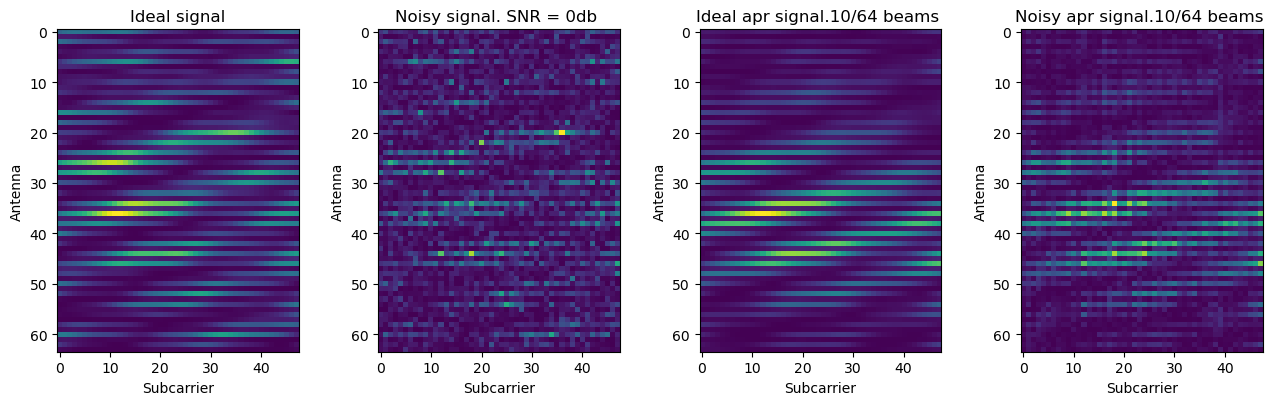

In [89]:
plt.figure(figsize=(13,4))
plt.subplot(1,4,1)
plt.imshow(abs(H_ant)**2)
plt.ylabel('Antenna'); plt.xlabel('Subcarrier');plt.title('Ideal signal')

plt.subplot(1,4,2)
plt.imshow(abs(U_ant)**2)
plt.ylabel('Antenna'); plt.xlabel('Subcarrier'); plt.title('Noisy signal. SNR = {0}db '.format(SNR))

plt.subplot(1,4,3)
plt.imshow(abs(H_ant_apr)**2)
plt.ylabel('Antenna');plt.xlabel('Subcarrier');plt.title('Ideal apr signal.{0}/{1} beams '.format(CLEAR_BEAMS, BEAMS))

plt.subplot(1,4,4)
plt.imshow(abs(U_ant_apr)**2)
plt.ylabel('Antenna');plt.xlabel('Subcarrier');plt.title('Noisy apr signal.{0}/{1} beams '.format(CLEAR_BEAMS, BEAMS))
plt.tight_layout()

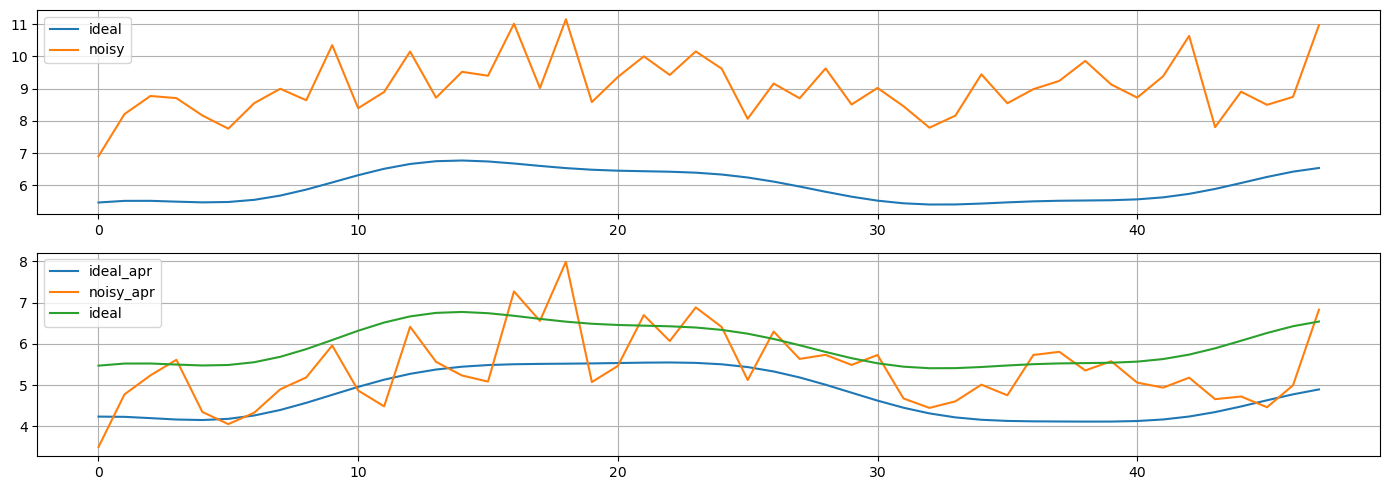

In [71]:
plt.figure(figsize=(14,5))
plt.subplot(2,1,1)
plt.plot(torch.sum((abs(H_ant)**2), dim = 0), label = 'ideal')
plt.plot(torch.sum((abs(U_ant)**2), dim = 0), label = 'noisy')
plt.legend()
plt.grid()

plt.subplot(2,1,2)
plt.plot(torch.sum((abs(H_ant_apr)**2), dim = 0), label = 'ideal_apr')
plt.plot(torch.sum((abs(U_ant_apr)**2), dim = 0), label = 'noisy_apr')
plt.plot(torch.sum((abs(H_ant)**2), dim = 0), label = 'ideal')
plt.legend()
plt.grid()
plt.tight_layout()